In [1]:
import sys

sys.path.append("/p/home/jusers/pierschke1/shared/HyperBrain")
sys.path.append("/p/home/jusers/pierschke1/shared/HyperBrain\\source")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.loftr.backbone import ResNetFPN_8_2
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from torch.utils.data import DataLoader
import torch
from einops.einops import rearrange
from torchvision.transforms import v2
from source.data_processing.image_reading import read_image
from torchvision.transforms import ToTensor
from source.data_processing.keypoints import translate_patch_midpoints_and_refine
import matplotlib.pyplot as plt
import numpy as np
from source.miscellaneous.evaluation import load_deformation
from source.visualization.image_visualization import plot_images_with_keypoint_matches
from kornia.geometry.ransac import RANSAC
from source.data_processing.cropping import crop_image

In [3]:
matches = torch.load(f"../../models/coarse_matching/8/matches.pt")
deformation = load_deformation()
image_1 = read_image("../../data/cyto_downscaled_3344_3904_evaluation/B20_0524_Slice15.tif")
image_2 = read_image("../../data/cyto_downscaled_3344_3904_evaluation/B20_0525_Slice15.tif")
image_1, image_2 = ToTensor()(image_1), ToTensor()(image_2)

image_1, image_2 = v2.Normalize(mean=[0.594], std=[0.204])(image_1), v2.Normalize(mean=[0.594], std=[0.204])(image_2)

In [4]:
matches.shape

torch.Size([8127, 4])

In [5]:
image_1_visualization_adjusted = torch.concatenate((image_1, torch.zeros(1, 8000, 205)), dim=2)
image_2_visualization_adjusted = torch.concatenate((image_2, torch.zeros(1, 618, 3668)), dim=1)

In [6]:
image_1_visualization_adjusted.shape, image_2_visualization_adjusted.shape

(torch.Size([1, 8000, 3667]), torch.Size([1, 8000, 3668]))

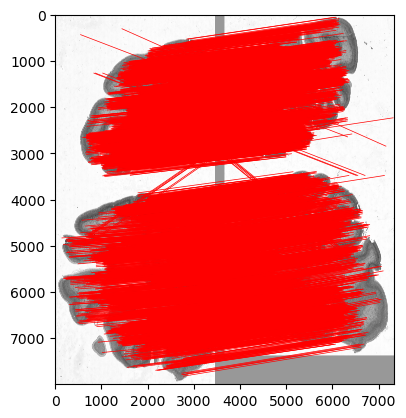

In [66]:
plot_images_with_keypoint_matches(image_1_visualization_adjusted, 
                                  image_2_visualization_adjusted, 
                                  matches[:, :2], 
                                  matches[:, 2:],)

In [117]:
from sklearn.cluster import OPTICS

matches_np = matches.numpy()
clustering = OPTICS(min_samples=5, max_eps=50).fit(matches_np)

# Iterate through the clusters and keep one match from each
matches_optics = []
for cluster_id in np.unique(clustering.labels_):
    cluster_indices = np.where(clustering.labels_ == cluster_id)[0]
    unique_match = matches_np[cluster_indices[0]]
    matches_optics.append(unique_match)

matches_optics = torch.tensor(matches_optics)

print(f"Original number of matches: {len(matches_np)}")
print(f"Filtered number of matches: {len(matches_optics)}")

Original number of matches: 8127
Filtered number of matches: 472


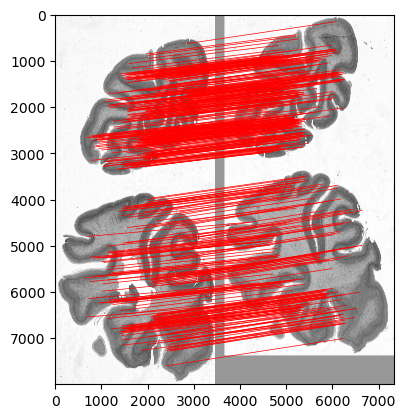

In [118]:
plot_images_with_keypoint_matches(image_1_visualization_adjusted, 
                                  image_2_visualization_adjusted, 
                                  matches_optics[:, :2], 
                                  matches_optics[:, 2:],)

In [119]:
confidence_threshold = 0.9
crop_size = 480

model_path = "../../models/40"
attention = "linear"
temperature = 0.2
block_dimension = [128, 196, 256]
fine_feature_size = block_dimension[0]
backbone = ResNetFPN_8_2(block_dimensions=block_dimension).cuda()
patch_size = 8


coarse_feature_size = block_dimension[-1]
state_dict_backbone = torch.load(f"{model_path}/backbone.pt")
state_dict_backbone = {k.replace("module.", ""): v for k, v in state_dict_backbone.items()}
backbone.load_state_dict(state_dict_backbone)

positional_encoding = PositionalEncoding(coarse_feature_size).cuda()

coarse_loftr = LocalFeatureTransformer(
feature_dimension=coarse_feature_size,
number_of_heads=8,
layer_names=["self", "cross"] * 4,
attention_type=attention
).cuda()
state_dict_coarse_loftr = torch.load(f"{model_path}/coarse_loftr.pt") 
state_dict_coarse_loftr = {k.replace("module.", ""): v for k, v in state_dict_coarse_loftr.items()}
coarse_loftr.load_state_dict(state_dict_coarse_loftr)

coarse_matcher = CoarseMatching(
temperature=temperature, confidence_threshold=confidence_threshold
).cuda()

fine_preprocess = FinePreprocess(
coarse_feature_size=coarse_feature_size,
fine_feature_size=fine_feature_size,
window_size=5,
use_coarse_context=False,
).cuda()

fine_loftr = LocalFeatureTransformer(
feature_dimension=fine_feature_size,
number_of_heads=8,
layer_names=["self", "cross"],
attention_type=attention
).cuda()

state_dict_fine_loftr = torch.load(f"{model_path}/fine_loftr.pt")
state_dict_fine_loftr = {k.replace("module.", ""): v for k, v in state_dict_fine_loftr.items()}
fine_loftr.load_state_dict(state_dict_fine_loftr)

fine_matching = FineMatching().cuda()

In [120]:
matches[::17, :].shape

torch.Size([479, 4])

In [121]:
matches_image_1_fine = []
matches_image_2_fine = []

with torch.no_grad():
    for coarse_match in matches_optics:
        match_image_1 = coarse_match[:2]
        match_image_2 = coarse_match[2:]

        crop_1 = crop_image(image_1, match_image_1.long(), crop_size)
        crop_2 = crop_image(image_2, match_image_2.long(), crop_size)

        # Skip crops that are not of the correct size
        if crop_1.shape[-1] != crop_size or crop_1.shape[-2] != crop_size or crop_2.shape[-1] != crop_size or crop_2.shape[-2] != crop_size:
            continue

        crop_1 = crop_1.cuda().unsqueeze(0)
        crop_2 = crop_2.cuda().unsqueeze(0)


        coarse_image_feature_1, fine_image_feature_1 = backbone(crop_1)
        coarse_image_feature_2, fine_image_feature_2 = backbone(crop_2)

        fine_height_width = fine_image_feature_1.shape[-1]
        coarse_height_width = coarse_image_feature_1.shape[-1]

        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        coarse_image_feature_1 = rearrange(
            coarse_image_feature_1, "n c h w -> n (h w) c"
        )
        coarse_image_feature_2 = rearrange(
            coarse_image_feature_2, "n c h w -> n (h w) c"
        )

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
            coarse_image_feature_1, coarse_image_feature_2
        )

        coarse_matches_predicted = coarse_matcher(
            coarse_image_feature_1, coarse_image_feature_2
        )
        match_matrix_predicted = coarse_matches_predicted["match_matrix"]

        (
            fine_image_feature_1_unfold,
            fine_image_feature_2_unfold,
        ) = fine_preprocess(
            coarse_image_feature_1=coarse_image_feature_1,
            coarse_image_feature_2=coarse_image_feature_2,
            fine_image_feature_1=fine_image_feature_1,
            fine_image_feature_2=fine_image_feature_2,
            coarse_matches=coarse_matches_predicted,
            fine_height_width=fine_height_width,
            coarse_height_width=coarse_height_width
        )
        
        # Skip crops that do not contain any matches
        if fine_image_feature_1_unfold.size(0) == 0:
            continue

        fine_image_feature_1_unfold = fine_image_feature_1_unfold.to("cuda")
        fine_image_feature_2_unfold = fine_image_feature_2_unfold.to("cuda")


        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(fine_image_feature_1_unfold, fine_image_feature_2_unfold)

        

        predicted_relative_coordinates = fine_matching(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        match_matrix_predicted = match_matrix_predicted.cpu()
        predicted_relative_coordinates = predicted_relative_coordinates.cpu()

        (
            crop_1_patch_mid_coordinates,
            crop_2_patch_mid_coordinates,
            crop_2_patch_mid_coordinates_refined,
        ) = translate_patch_midpoints_and_refine(
            match_matrix=match_matrix_predicted,
            patch_size=patch_size,
            relative_coordinates=predicted_relative_coordinates,
            fine_feature_size=fine_image_feature_1.shape[-1]
        )

        crop_1_patch_mid_coordinates = crop_1_patch_mid_coordinates.float()
        crop_1_patch_mid_coordinates += match_image_1
        crop_2_patch_mid_coordinates_refined += match_image_2

        # if crop_1_patch_mid_coordinates.shape[0] < 4:
        #     continue

        # ransac = RANSAC()
        # M, inliers = ransac(crop_1_patch_mid_coordinates, crop_2_patch_mid_coordinates_refined)
        # inliers = inliers.squeeze()

        # matches_image_1_fine.append(crop_1_patch_mid_coordinates[inliers])
        # matches_image_2_fine.append(crop_2_patch_mid_coordinates_refined[inliers])
        matches_image_1_fine.append(crop_1_patch_mid_coordinates)
        matches_image_2_fine.append(crop_2_patch_mid_coordinates_refined)

In [127]:
matches_image_1_fine, matches_image_2_fine = torch.cat(matches_image_1_fine), torch.cat(matches_image_2_fine)

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [123]:
from source.miscellaneous.evaluation import evaluate_test_image_pair

In [128]:
(
    number_of_matches,
    average_distance,
    match_precision,
    auc,
    matches_per_patch,
    entropy,
) = evaluate_test_image_pair(matches_image_1_fine, matches_image_2_fine, deformation)
print(
    f"Number of matches: {number_of_matches}\nAverage distance: {average_distance}\nAUC: {auc}\nEntropy: {entropy}"
)

Number of matches: 6220
Average distance: 2.5307071208953857
AUC: 7.601684895753278
Entropy: 8.847823143005371


In [129]:
from source.visualization.evaluation_visualization import *

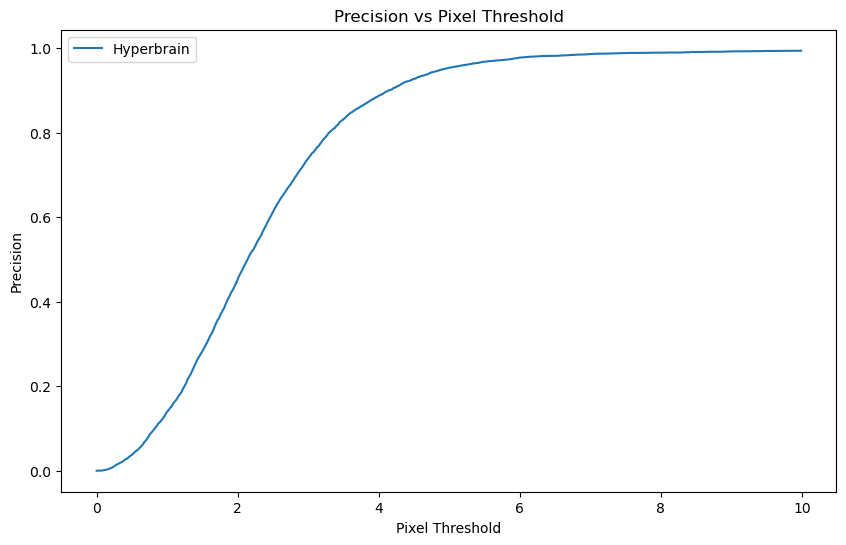

In [130]:
plot_precision_vs_threshold(match_precision, labels=["Hyperbrain"])

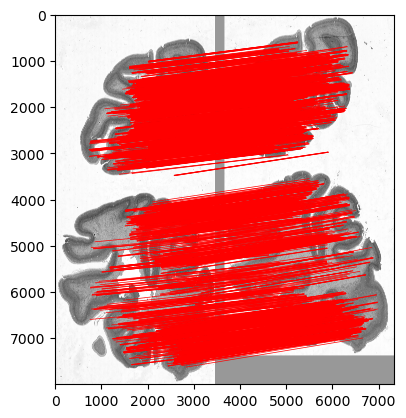

In [131]:
plot_images_with_keypoint_matches(image_1_visualization_adjusted, 
                                  image_2_visualization_adjusted, 
                                  matches_image_1_fine, 
                                  matches_image_2_fine)